# Model Training

In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

## Data Processing

In [2]:
data_clean = pd.read_csv('data/data_clean_double3.csv')
data_clean.head()

,Unnamed: 0,Year,home_team,home_gdp,home_population,home_oddset,home_fifa_rank,home_host,away_team,away_gdp,away_population,away_oddset,away_fifa_rank,away_host,home_goal,away_goal,win_point,result
0,0,1930,FRA,46984,6528,550,2,0,MEX,18445,12894,15000,11,0,4,1,3,1
1,1,1930,USA,63594,33101,10000,20,0,BEL,53035,1159,1200,1,0,3,0,3,1
2,2,1930,ROU,32117,1924,200000,43,0,PER,11879,3298,20000,27,0,3,1,2,1
3,3,1930,ARG,20771,4520,900,8,0,FRA,46984,6528,550,2,0,1,0,1,1
4,4,1930,ARG,20771,4520,900,8,0,MEX,18445,12894,15000,11,0,6,3,3,1


In [3]:
# generate rank
fifa = pd.read_csv('data/fifa.csv')
f = lambda x: str(x[:4])
rank_year = fifa['rank_date'].apply(f)
fifa = fifa.drop(columns = ['rank_date'])
fifa['rank_year'] = rank_year
def get_fifa_rank_records(name,year):
    country_records = fifa.loc[(fifa['country_abrv']==name)]
    country_records['rank_year'] = country_records['rank_year'].astype(int)
    country_records.sort_values("rank_year",inplace=True, ascending=False)
    records = country_records.loc[country_records['rank_year']<=year]
    return records

### Add feature columns

In [4]:
# add Features columns
# add Total GDP difference between home and away
data_clean['GDP_Diff'] = data_clean['home_gdp'] - data_clean['away_gdp']
# add GDP per capita between home and away
data_clean['PersonGDP_Diff'] = (data_clean['home_gdp']/data_clean['home_population']) - (data_clean['away_gdp']/data_clean['away_population'])
# add population difference
data_clean['Population_Diff'] = data_clean['home_population'] - data_clean['away_population']
# add oddset difference
data_clean['Oddset_Diff'] = data_clean['home_oddset'] - data_clean['away_oddset']
# add rank difference
data_clean['Rank_Diff'] = data_clean['home_fifa_rank'] - data_clean['away_fifa_rank']
data_clean.head()

,Unnamed: 0,Year,home_team,home_gdp,home_population,home_oddset,home_fifa_rank,home_host,away_team,away_gdp,...,away_host,home_goal,away_goal,win_point,result,GDP_Diff,PersonGDP_Diff,Population_Diff,Oddset_Diff,Rank_Diff
0,0,1930,FRA,46984,6528,550,2,0,MEX,18445,...,0,4,1,3,1,28539,5.766794,-6366,-14450,-9
1,1,1930,USA,63594,33101,10000,20,0,BEL,53035,...,0,3,0,3,1,10559,-43.838064,31942,8800,19
2,2,1930,ROU,32117,1924,200000,43,0,PER,11879,...,0,3,1,2,1,20238,13.090948,-1374,180000,16
3,3,1930,ARG,20771,4520,900,8,0,FRA,46984,...,0,1,0,1,1,-26213,-2.601950,-2008,350,6
4,4,1930,ARG,20771,4520,900,8,0,MEX,18445,...,0,6,3,3,1,2326,3.164844,-8374,-14100,-3


In [5]:
# caculate the win/draw/lose rate use the previous data
# for example: 2018 USA(home) vs FRA(away)
#              Team_Total = all data from 1930-2014 where USA is included
#              Win = all data from 1930-2014 where USA is winner
#              Home_Win_Rate = Win / Team_Total
# caculate the Average goal difference
# for example: 2018 USA(home) vs FRA(away)
#              Team_Total = all data from 1930-2014 where USA is included
#              WinGoals = all goals from 1930-2014 where USA is winner
#              Home_Goal_Avg = WinGoals / Team_Total
def calculate_rate(dataset,TeamHome,TeamAway,Year):
  Home_Team_Total = dataset.loc[((dataset['home_team']==TeamHome)&(dataset['Year']<Year))]
  Home_Team_Total2 = dataset.loc[((dataset['away_team']==TeamHome)&(dataset['Year']<Year))]
  Home_Team_Win = dataset.loc[((dataset['home_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == 1))]
  Home_Team_Win2 = dataset.loc[((dataset['away_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == -1))]
  Home_Team_Draw = dataset.loc[((dataset['home_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == 0))]
  Home_Team_Draw2 = dataset.loc[((dataset['away_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == 0))]
  Home_Team_Lose = dataset.loc[((dataset['home_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == -1))]
  Home_Team_Lose2 = dataset.loc[((dataset['away_team']==TeamHome)&(dataset['Year']<Year)&(dataset['result'] == 1))]
  Home_Team_Total_Goals = Home_Team_Total['home_goal'].sum() + Home_Team_Total2['away_goal'].sum()

  TotalHome = Home_Team_Total['Year'].count() + Home_Team_Total2['Year'].count()
  if TotalHome == 0:
    Home_Team_Win_Percentage = 0
    Home_Team_Draw_Percentage = 0
    Home_Team_Lose_Percentage = 0
    Home_Team_Win_Goals_Avg = 0
    Home_Team_Lose_Goals_Avg = 0
    Home_Team_AVG_Goals = 0
  else:
    Home_Team_Win_Percentage = (Home_Team_Win['Year'].count() + Home_Team_Win2['Year'].count())/TotalHome
    Home_Team_Draw_Percentage = (Home_Team_Draw['Year'].count() + Home_Team_Draw2['Year'].count())/TotalHome
    Home_Team_Lose_Percentage = (Home_Team_Lose['Year'].count() + Home_Team_Lose2['Year'].count())/TotalHome
    Home_Team_Win_Goals_Avg = (Home_Team_Win['win_point'].sum() - Home_Team_Win2['win_point'].sum())/TotalHome
    Home_Team_Lose_Goals_Avg = (Home_Team_Lose['win_point'].sum() - Home_Team_Lose2['win_point'].sum())/TotalHome
    Home_Team_AVG_Goals = Home_Team_Total_Goals / TotalHome

  Away_Team_Total = dataset.loc[((dataset['away_team']==TeamAway)&(dataset['Year']<Year))]
  Away_Team_Total2 = dataset.loc[((dataset['home_team']==TeamAway)&(dataset['Year']<Year))]
  Away_Team_Win = dataset.loc[((dataset['away_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == -1))]
  Away_Team_Win2 = dataset.loc[((dataset['home_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == 1))]
  Away_Team_Draw = dataset.loc[((dataset['away_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == 0))]
  Away_Team_Draw2 = dataset.loc[((dataset['home_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == 0))]
  Away_Team_Lose = dataset.loc[((dataset['away_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == 1))]
  Away_Team_Lose2 = dataset.loc[((dataset['home_team']==TeamAway)&(dataset['Year']<Year)&(dataset['result'] == -1))]
  Away_Team_Total_Goals = Away_Team_Total['away_goal'].sum() + Away_Team_Total2['home_goal'].sum()

  TotalAway = Away_Team_Total['Year'].count() + Away_Team_Total2['Year'].count()
  if TotalAway == 0:
    Away_Team_Win_Percentage = 0
    Away_Team_Draw_Percentage = 0
    Away_Team_Lose_Percentage = 0
    Away_Team_Win_Goals_Avg = 0
    Away_Team_Lose_Goals_Avg = 0
    Away_Team_AVG_Goals = 0
  else:
    Away_Team_Win_Percentage = (Away_Team_Win['Year'].count() + Away_Team_Win2['Year'].count())/TotalAway
    Away_Team_Draw_Percentage = (Away_Team_Draw['Year'].count() + Away_Team_Draw2['Year'].count())/TotalAway
    Away_Team_Lose_Percentage = (Away_Team_Lose['Year'].count() + Away_Team_Lose2['Year'].count())/TotalAway
    Away_Team_Win_Goals_Avg = (Away_Team_Win2['win_point'].sum() - Away_Team_Win['win_point'].sum())/TotalAway
    Away_Team_Lose_Goals_Avg = (Away_Team_Lose2['win_point'].sum() - Away_Team_Lose['win_point'].sum())/TotalAway
    Away_Team_AVG_Goals = Away_Team_Total_Goals / TotalAway

  Win_Rate_Diff = Home_Team_Win_Percentage - Away_Team_Win_Percentage
  Draw_Rate_Diff = Home_Team_Draw_Percentage - Away_Team_Draw_Percentage 
  Lose_Rate_Diff = Home_Team_Lose_Percentage - Away_Team_Lose_Percentage
  Win_Goals_Diff = Home_Team_Win_Goals_Avg - Away_Team_Win_Goals_Avg
  Lose_Goals_Diff = Home_Team_Lose_Goals_Avg - Away_Team_Lose_Goals_Avg
  AVG_Goals_Diff = Home_Team_AVG_Goals - Away_Team_AVG_Goals

  return {'Home_Team_Win_Rate': Home_Team_Win_Percentage,
        'Home_Team_Draw_Rate': Home_Team_Draw_Percentage,
        'Home_Team_Lose_Rate':Home_Team_Lose_Percentage,
        'Away_Team_Win_Rate': Away_Team_Win_Percentage,
        'Away_Team_Draw_Rate': Away_Team_Draw_Percentage,
        'Away_Team_Lose_Rate': Away_Team_Lose_Percentage,
        'Win_Rate_Diff': Win_Rate_Diff,
        'Draw_Rate_Diff': Draw_Rate_Diff,
        'Lose_Rate_Diff': Lose_Rate_Diff,
        'Home_Team_Win_Goals_Avg': Home_Team_Win_Goals_Avg,
        'Home_Team_Lose_Goals_Avg': Home_Team_Lose_Goals_Avg,
        'Away_Team_Win_Goals_Avg': Away_Team_Win_Goals_Avg,
        'Away_Team_Lose_Goals_Avg': Away_Team_Lose_Goals_Avg,
        'Win_Goals_Diff': Win_Goals_Diff,
        'Lose_Goals_Diff': Lose_Goals_Diff,
        'Home_Team_AVG_Goals': Home_Team_AVG_Goals,
        'Away_Team_AVG_Goals': Away_Team_AVG_Goals,
        'AVG_Goals_Diff': AVG_Goals_Diff
        }

### Input

In [6]:
# Create the new dataframe for Machine Learning input
FinalData = []
for index, row in data_clean.iterrows():
  ProcessedData = {}
  Rate = calculate_rate(data_clean,row['home_team'],row['away_team'],row['Year'])
  ProcessedData['Year'] = row['Year']
  ProcessedData['home_team'] = row['home_team']
  ProcessedData['away_team'] = row['away_team']
  ProcessedData['result'] = row['result']
  ProcessedData['GDP_Diff'] = row['GDP_Diff']
  ProcessedData['PersonGDP_Diff'] = row['PersonGDP_Diff']
  ProcessedData['Population_Diff'] = row['Population_Diff']
  ProcessedData['Oddset_Diff'] = row['Oddset_Diff']
  ProcessedData['Rank_Diff'] = row['Rank_Diff']
  ProcessedData['Home_Team_Win_Rate'] = Rate['Home_Team_Win_Rate']
  ProcessedData['Home_Team_Draw_Rate'] = Rate['Home_Team_Draw_Rate']
  ProcessedData['Home_Team_Lose_Rate'] = Rate['Home_Team_Lose_Rate']
  ProcessedData['Away_Team_Win_Rate'] = Rate['Away_Team_Win_Rate']
  ProcessedData['Away_Team_Draw_Rate'] = Rate['Away_Team_Draw_Rate']
  ProcessedData['Away_Team_Lose_Rate'] = Rate['Away_Team_Lose_Rate']
  ProcessedData['Win_Rate_Diff'] = Rate['Win_Rate_Diff']
  ProcessedData['Draw_Rate_Diff'] = Rate['Draw_Rate_Diff']
  ProcessedData['Lose_Rate_Diff'] = Rate['Lose_Rate_Diff']
  ProcessedData['Home_Team_Win_Goals_Avg'] = Rate['Home_Team_Win_Goals_Avg']
  ProcessedData['Home_Team_Lose_Goals_Avg'] = Rate['Home_Team_Lose_Goals_Avg']
  ProcessedData['Away_Team_Win_Goals_Avg'] = Rate['Away_Team_Win_Goals_Avg']
  ProcessedData['Away_Team_Lose_Goals_Avg'] = Rate['Away_Team_Lose_Goals_Avg']
  ProcessedData['Win_Goals_Diff'] = Rate['Win_Goals_Diff']
  ProcessedData['Lose_Goals_Diff'] = Rate['Lose_Goals_Diff']
  ProcessedData['Home_Team_AVG_Goals'] = Rate['Home_Team_AVG_Goals']
  ProcessedData['Away_Team_AVG_Goals'] = Rate['Away_Team_AVG_Goals']
  ProcessedData['AVG_Goals_Diff'] = Rate['AVG_Goals_Diff']
  ProcessedData['Sample_weights'] = ((row['Year'] % 1930) / 4 + 1)*(0.045)
  FinalData.append(ProcessedData)
Final_Processed_Data = pd.DataFrame(FinalData)
Final_Processed_Data = Final_Processed_Data.fillna(0)
Final_Processed_Data.head()


,Year,home_team,away_team,result,GDP_Diff,PersonGDP_Diff,Population_Diff,Oddset_Diff,Rank_Diff,Home_Team_Win_Rate,...,Home_Team_Win_Goals_Avg,Home_Team_Lose_Goals_Avg,Away_Team_Win_Goals_Avg,Away_Team_Lose_Goals_Avg,Win_Goals_Diff,Lose_Goals_Diff,Home_Team_AVG_Goals,Away_Team_AVG_Goals,AVG_Goals_Diff,Sample_weights
0,1930,FRA,MEX,1,28539,5.766794,-6366,-14450,-9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
1,1930,USA,BEL,1,10559,-43.838064,31942,8800,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
2,1930,ROU,PER,1,20238,13.090948,-1374,180000,16,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
3,1930,ARG,FRA,1,-26213,-2.601950,-2008,350,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045
4,1930,ARG,MEX,1,2326,3.164844,-8374,-14100,-3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045


In [7]:
Final_Processed_Data.to_csv('ProcessedDataForInput.csv')

In [8]:
Final_Processed_Data.columns

Index(['Year', 'home_team', 'away_team', 'result', 'GDP_Diff',
       'PersonGDP_Diff', 'Population_Diff', 'Oddset_Diff', 'Rank_Diff',
       'Home_Team_Win_Rate', 'Home_Team_Draw_Rate', 'Home_Team_Lose_Rate',
       'Away_Team_Win_Rate', 'Away_Team_Draw_Rate', 'Away_Team_Lose_Rate',
       'Win_Rate_Diff', 'Draw_Rate_Diff', 'Lose_Rate_Diff',
       'Home_Team_Win_Goals_Avg', 'Home_Team_Lose_Goals_Avg',
       'Away_Team_Win_Goals_Avg', 'Away_Team_Lose_Goals_Avg', 'Win_Goals_Diff',
       'Lose_Goals_Diff', 'Home_Team_AVG_Goals', 'Away_Team_AVG_Goals',
       'AVG_Goals_Diff', 'Sample_weights'],
      dtype='object')

In [9]:
# split Trainset and Testset
from sklearn.model_selection import train_test_split

DropC = ['result','home_team','away_team','Year','PersonGDP_Diff','Oddset_Diff','GDP_Diff','Population_Diff',
         'Home_Team_Win_Rate', 'Home_Team_Draw_Rate', 'Home_Team_Lose_Rate','Away_Team_Win_Rate', 'Away_Team_Draw_Rate', 'Away_Team_Lose_Rate',
         'Home_Team_Win_Goals_Avg', 'Home_Team_Lose_Goals_Avg','Away_Team_Win_Goals_Avg', 'Away_Team_Lose_Goals_Avg',
         'Home_Team_AVG_Goals', 'Away_Team_AVG_Goals']
X = Final_Processed_Data.drop(DropC, axis=1)
Y = Final_Processed_Data["result"]
Y = Y.astype('int')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
X_train

,Rank_Diff,Win_Rate_Diff,Draw_Rate_Diff,Lose_Rate_Diff,Win_Goals_Diff,Lose_Goals_Diff,AVG_Goals_Diff,Sample_weights
82,-24,0.428571,0.000000,-0.428571,1.190476,0.952381,1.380952,0.585
39,26,0.666667,0.000000,-0.666667,2.833333,2.700000,2.966667,0.360
531,27,0.000000,0.375000,-0.375000,-0.125000,0.083333,-0.083333,0.945
79,-20,0.261905,0.000000,-0.261905,1.690476,0.619048,2.130952,0.585
2,16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045
...,...,...,...,...,...,...,...,...
71,-30,0.025000,0.087500,-0.112500,-0.987500,0.087500,-1.112500,0.585
106,5,-0.180952,0.092857,0.088095,-0.559524,0.019048,-0.692857,0.630
270,35,0.015385,-0.030769,0.015385,-0.130769,0.015385,-0.338462,0.990
435,-5,-0.166667,0.000000,0.166667,-0.500000,1.500000,-0.166667,0.765


### Add Sample weights

In [10]:
SampleWeight = X_train['Sample_weights']
X_train = X_train.drop(['Sample_weights'],axis=1)
X_test = X_test.drop(['Sample_weights'],axis=1)

In [11]:
def confusion_matrix_plot(cm):
    ax= sns.heatmap(cm, annot=True, fmt="d")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Loss', 'Draw','Win'])
    ax.yaxis.set_ticklabels(['Loss', 'Draw','Win'])
    return ax

## Model Training

### KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=36)
knn.fit(X_train,Y_train)
y_predictions_knn = knn.predict(X_test)

Trainscore = knn.score(X_train, Y_train)
Testscore = knn.score(X_test, Y_test)
print("Training Accuracy: {0:.0f}%".format(Trainscore * 100)) 
print("Test Accuracy: {0:.0f}%".format(Testscore * 100)) 

Training Accuracy: 58%
Test Accuracy: 56%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

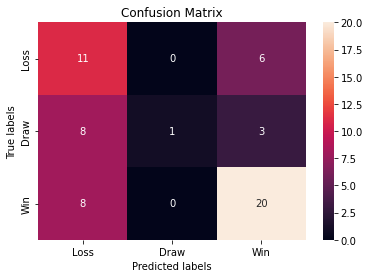

In [13]:
cm=confusion_matrix(Y_test, y_predictions_knn)
confusion_matrix_plot(cm)

Text(0, 0.5, 'accuracy')

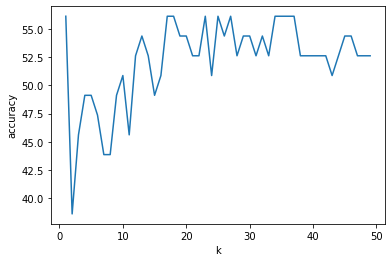

In [14]:
#The optimun number of neigbbors was determined through the following routine:
knn_list = range(1, 50)
accuracy_scores = []

for k in knn_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,Y_train)
    accuracy_scores.append(knn.score(X_test, Y_test) * 100)
   

plt.plot(knn_list, accuracy_scores)
plt.xlabel('k')
plt.ylabel('accuracy')

### Logistic Regression

In [15]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

LR = LogisticRegression()
LRC = LogisticRegressionCV(Cs=np.logspace(-4,4,20), cv=5, n_jobs=-1)

LR.fit(X_train, Y_train, sample_weight = SampleWeight)
LRC.fit(X_train, Y_train, sample_weight = SampleWeight)

Trainscore = LR.score(X_train, Y_train)
Testscore = LR.score(X_test, Y_test)
print("Training Accuracy: " + str(Trainscore))
print("Test Accuracy: "+ str(Testscore))

# predict from the model
predY = LRC.predict(X_test)
# calculate accuracy
acc = metrics.accuracy_score(Y_test, predY)
print("cv test accuracy=", acc)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.5828460038986355
Test Accuracy: 0.5789473684210527
cv test accuracy= 0.5789473684210527


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

### Linear SVM

In [16]:
# SVM
from sklearn import svm
classifier = svm.SVC(C=1.0, kernel='linear', gamma='auto')

# Considering the sample weight
classifier.fit(X_train, Y_train, sample_weight=SampleWeight)
TrainScore = classifier.score(X_train, Y_train)
TestScore = classifier.score(X_test, Y_test)
print("Training Accuracy:" + str(TrainScore))
print("Test Accuracy:" + str(TestScore))

Training Accuracy:0.5925925925925926
Test Accuracy:0.5789473684210527


### Kernel SVM with RBF kernel

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# setup the list of parameters to try
paramgrid = {'C': np.logspace(-2,3,20), 
             'gamma': np.logspace(-4,3,20) }
# setup the cross-validation object
# pass the SVM object w/ rbf kernel, parameter grid, and number of CV folds
svmcv = GridSearchCV(SVC(kernel='rbf'), paramgrid, cv=5, n_jobs=-1, verbose=True)
# run cross-validation (train for each split)
svmcv.fit(X_train,Y_train)

print("best params:", svmcv.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
best params: {'C': 297.63514416313194, 'gamma': 0.0001}


Training Accuracy: 59%
Test Accuracy: 56%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

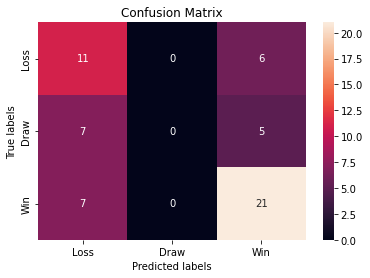

In [18]:
ksvm =svmcv.predict(X_test)
Trainscore = svmcv.score(X_train, Y_train)
Testscore = svmcv.score(X_test, Y_test)
print("Training Accuracy: {0:.0f}%".format(Trainscore * 100)) 
print("Test Accuracy: {0:.0f}%".format(Testscore * 100)) 
cm2=confusion_matrix(Y_test, ksvm)
confusion_matrix_plot(cm2)

### Ada Boost

In [19]:
from sklearn.ensemble import AdaBoostClassifier
# setup the list of parameters to try
paramgrid = {'learning_rate': np.logspace(-6,0,20), 
             'n_estimators': np.array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500])
            }
# setup the cross-validation object
# (NOTE: using parallelization in GridSearchCV, not in AdaBoost)
adacv = GridSearchCV(AdaBoostClassifier(random_state=4487),paramgrid, cv=5, n_jobs=-1)

# run cross-validation (train for each split)
adacv.fit(X_train, Y_train);

print("best params:", adacv.best_params_)

best params: {'learning_rate': 0.012742749857031322, 'n_estimators': 500}


Training Accuracy: 58%
Test Accuracy: 54%


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

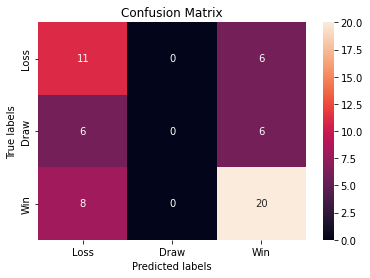

In [20]:
ada =adacv.predict(X_test)
Trainscore = adacv.score(X_train, Y_train)
Testscore = adacv.score(X_test, Y_test)
print("Training Accuracy: {0:.0f}%".format(Trainscore * 100)) 
print("Test Accuracy: {0:.0f}%".format(Testscore * 100)) 
cm=confusion_matrix(Y_test, ada)
confusion_matrix_plot(cm)

### XGBoost

In [21]:
# xgboost
# !pip install xgboost
# import xgboost as xgb
# from numpy import *
# from sklearn import *
# xclf = xgb.XGBClassifier(objective="multi:softmax", random_state=4487)
#paramgrid = {'learning_rate': logspace(-2,0,10), 
#              'n_estimators': array([10,20,30,40,50,60,70,80,90,100])
#             }
# print(paramgrid)
# xgbcv = model_selection.GridSearchCV(xclf, paramgrid, cv=5, n_jobs=-1)
# xgbcv.fit(X_train, Y_train,sample_weight = SampleWeight);
# print("best params:", xgbcv.best_params_)
# PredY = xgbcv.predict(X_test)
# Acc = metrics.accuracy_score(Y_test, PredY)
# print("test accuracy =", Acc)

### Decision Tree

In [22]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(min_samples_split=2, max_depth=10)  

dt.fit(X_train, Y_train, sample_weight = SampleWeight)              
Trainscore = dt.score(X_train, Y_train)
Testscore = dt.score(X_test, Y_test)
print("Training Accuracy: " + str(Trainscore)) 
print("Test Accuracy: "+ str(Testscore))

Training Accuracy: 0.797270955165692
Test Accuracy: 0.5087719298245614


In [23]:
featnames = [x.strip() for x in X_train.columns]
print(featnames)

['Rank_Diff', 'Win_Rate_Diff', 'Draw_Rate_Diff', 'Lose_Rate_Diff', 'Win_Goals_Diff', 'Lose_Goals_Diff', 'AVG_Goals_Diff']


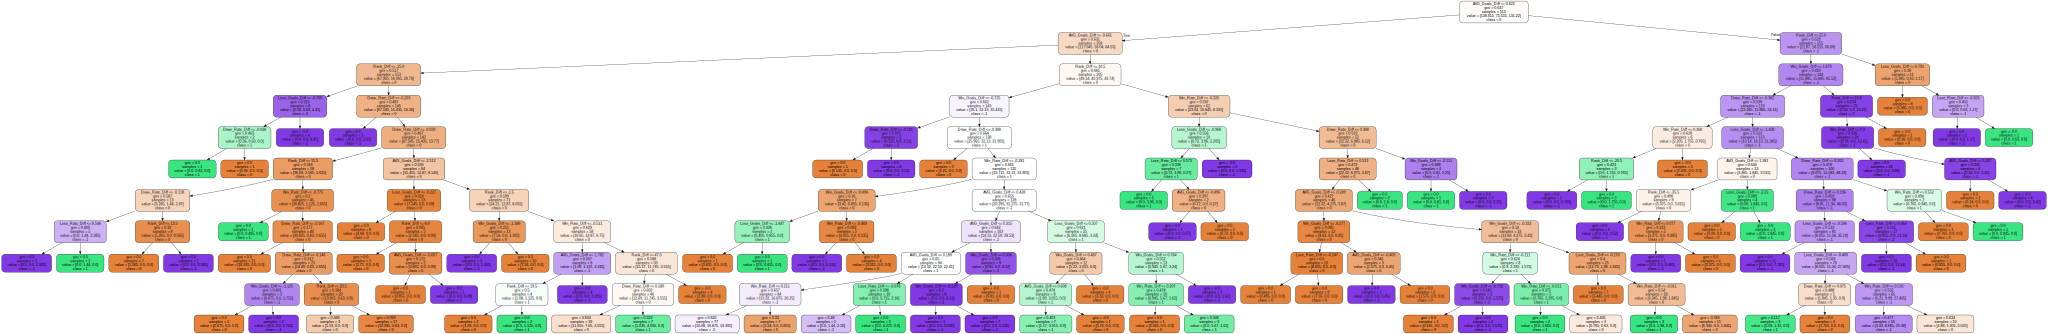

In [24]:
# !pip install graphviz
import graphviz
data=tree.export_graphviz(dt,feature_names=featnames
                     ,class_names=['0','1','-1']
                     ,filled=True
                     ,rounded=True
                    )
graph=graphviz.Source(data)
graph

### RandomForest

In [25]:
# Randomforest
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=15, random_state=7)
RF.fit(X_train, Y_train,sample_weight = SampleWeight)
Trainscore = RF.score(X_train, Y_train)
Testscore = RF.score(X_test, Y_test)
print("Training Accuracy: " + str(Trainscore)) 
print("Test Accuracy: "+ str(Testscore))

Training Accuracy: 0.9766081871345029
Test Accuracy: 0.631578947368421


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

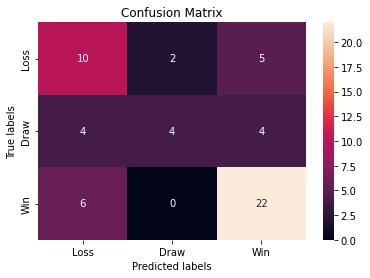

In [26]:
from sklearn.metrics import confusion_matrix 
pred_y = RF.predict(X_test)
cm = confusion_matrix(Y_test, pred_y)
confusion_matrix_plot(cm)

#### Confusion matrix and ROC curve for Random Forest

Random forest is the best classifier up to now, which accuracy is around 65%.   
From both confusion matrix and ROC curve, it could be clearly seen that our classifier has a good performance on predicting win/lose. However, it's hard for it to predice draw. 

In [27]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

Highest accuracy 64.91228070175438  on  89


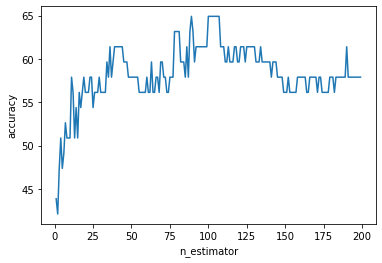

In [28]:
#Select number of trees

# highest_n = 0
# highest_acc = 0
# accuracy_scores = []
# n_list = range(1,200)
# for n in n_list:
#     RF = RandomForestClassifier(n_estimators=n, max_depth=7, random_state=7)
#     RF.fit(X_train, Y_train,sample_weight = SampleWeight)

#     accuracy_scores.append(RF.score(X_test, Y_test) * 100)
    
#     if RF.score(X_test, Y_test) * 100 > highest_acc:
#         highest_acc = RF.score(X_test, Y_test) * 100
#         highest_n = n
# plt.plot(n_list, accuracy_scores)
# plt.xlabel('n_estimator')
# plt.ylabel('accuracy')
# print("Highest accuracy", highest_acc, " on ", highest_n)

Highest accuracy 68.42105263157895  on  14


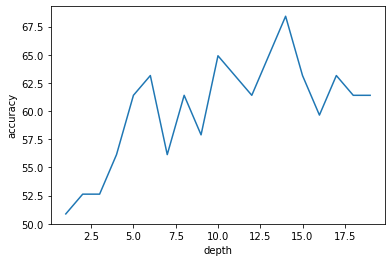

In [30]:
#Random forest
highest_d = 0
highest_acc = 0
accuracy_scores = []
n_list = range(1,20)
for n in n_list:
    RF = RandomForestClassifier(n_estimators=30, max_depth=n, random_state=7)
    RF.fit(X_train, Y_train,sample_weight = SampleWeight)

    accuracy_scores.append(RF.score(X_test, Y_test) * 100)
    
    if RF.score(X_test, Y_test) * 100 > highest_acc:
        highest_acc = RF.score(X_test, Y_test) * 100
        highest_d = n
plt.plot(n_list, accuracy_scores)
plt.xlabel('depth')
plt.ylabel('accuracy')
print("Highest accuracy", highest_acc, " on ", highest_d)

In [31]:
RF = RandomForestClassifier(n_estimators=30, max_depth=14, random_state=7)
RF.fit(X_train, Y_train,sample_weight = SampleWeight)
Trainscore = RF.score(X_train, Y_train)
Testscore = RF.score(X_test, Y_test)
print("Training Accuracy: " + str(Trainscore)) 
print("Test Accuracy: "+ str(Testscore))

Training Accuracy: 0.9688109161793372
Test Accuracy: 0.6842105263157895


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

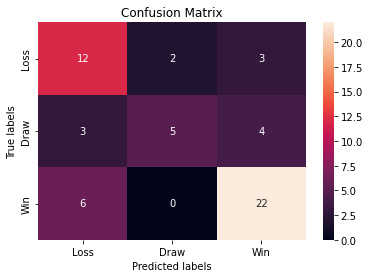

In [32]:
from sklearn.metrics import confusion_matrix 
pred_y = RF.predict(X_test)
cm = confusion_matrix(Y_test, pred_y)
confusion_matrix_plot(cm)

In [33]:
RF = RandomForestClassifier(n_estimators=30, max_depth=14, random_state=7)
RF.fit(X_train, Y_train,sample_weight = SampleWeight)
Trainscore = RF.score(X_train, Y_train)
Testscore = RF.score(X_test, Y_test)
print("Training Accuracy: " + str(Trainscore)) 
print("Test Accuracy: "+ str(Testscore))

Training Accuracy: 0.9688109161793372
Test Accuracy: 0.6842105263157895


In [34]:
y_score = RF.predict_proba(X_test)
Y = label_binarize(Y_test, classes=[-1, 0, 1])
n_classes = Y.shape[1]

In [35]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

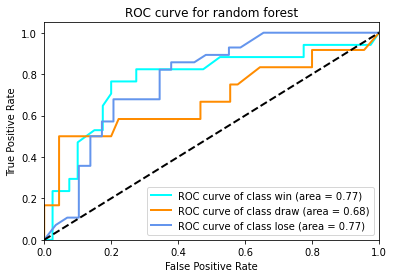

In [36]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
class_names = ["win", "draw", "lose"]

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for random forest")
plt.legend(loc="lower right")
plt.show()